In [1]:
import sys

sys.path.append('./source/')

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from scipy import interpolate as intp
import importlib
import healpy


from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.01,
 'M_max': 10000000000.0,
 'fwimp': 1.7896346444957159,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -15,
 'log_flux_max': -5,
 'N': 1000,
 'log_k_min': -3,
 'log_k_max': 6,
 'N_k': 250000,
 'psh_log_f_min': -7,
 'psh_log_f_max': -2.5,
 'N_psh': 1000,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5570.423008216337,
 'iso_flux_bg': 0.0008939106670451649,
 'gal_flux_bg_file': './output/gal_flux_bg.npy',
 'bg': 1,
 'beg': 1}

In [4]:
pltparams = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(pltparams)

colors = ['xkcd:pig pink', 'xkcd:windows blue']
n_labels = [r"$s$-wave ($n=0$)", r"Som. enh. ($n=-1$)"]

psi = 100

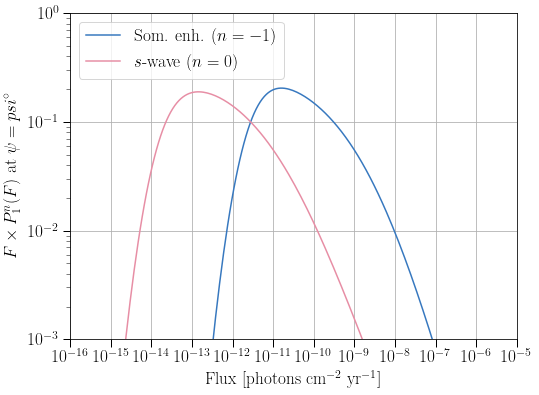

In [5]:
outfile = "./output/plots/p1_ssom.pdf"
fig, ax = plots.p1_plot(p, n_list=[-1, 0], psi=psi, outfile=outfile, colors=iter(reversed(colors)))
ax.set_xlim(left=1e-16, right=1e-5)
ax.set_ylim(bottom=1e-3, top=1)
fig.savefig(outfile)

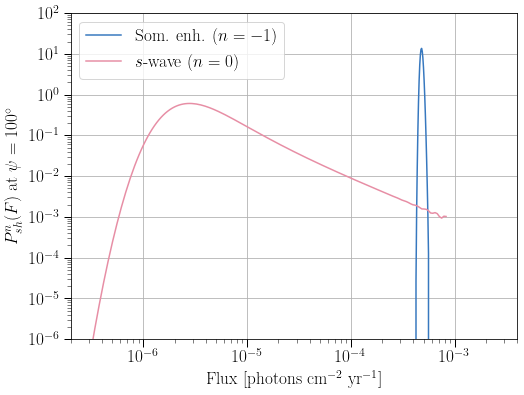

In [8]:
with np.load('./output/n-1_pshfunc_take2.npz') as f:
    psis = f['psi']
    fluxes = f['flux']
    psh2d = f['psh']

psh2d[psh2d < 0] = 0
sompshfunc2d = intp.interp2d(psis, fluxes, np.nan_to_num(psh2d), bounds_error=False, fill_value=0)
somfluxes = fluxes[70:-55]
    
with np.load('./output/n0_pshfunc.npz') as f:
    psis = f['psi']
    fluxes = f['flux']
    psh2d = f['psh']

pshfunc2d = intp.interp2d(psis, fluxes, np.nan_to_num(psh2d), bounds_error=False, fill_value=0)
fluxes = fluxes[10:-65]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(somfluxes, somfluxes * sompshfunc2d(psi, somfluxes).flatten(), label=n_labels[-1], color=colors[-1])

ax.plot(fluxes, fluxes * pshfunc2d(psi, fluxes).flatten(), label=n_labels[0], color=colors[0])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Flux [photons cm$^{-2}$ yr$^{-1}$]')
ax.set_ylabel(rf'$P^n_{{sh}}(F)$ at $\psi={psi}^\circ$')

ax.set_xlim(left=2e-7, right=4e-3)
ax.set_ylim(bottom=1e-6, top=100)
ax.grid()
ax.legend(loc='upper left')

fig.savefig('./output/plots/psh_ssom.pdf')

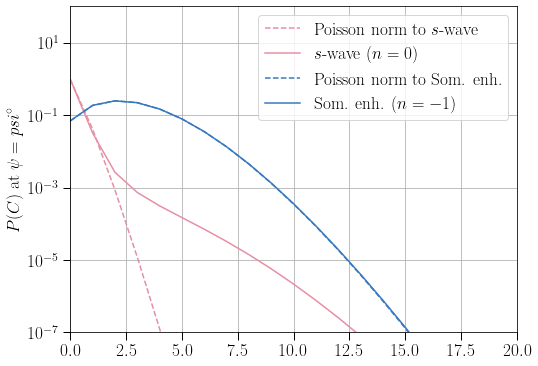

In [17]:
from scipy.stats import poisson

counts = np.arange(0, 18)
exposure = p['exposure']

pp = poisson.pmf(counts, exposure*np.trapz(fluxes * pshfunc2d(psi, fluxes).flatten(), fluxes))

pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)


ppsom = poisson.pmf(counts, exposure*np.trapz(somfluxes * sompshfunc2d(psi, somfluxes).flatten(), somfluxes))

pcsomvals = np.trapz(sompshfunc2d(psi, somfluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * somfluxes), somfluxes, axis=-1)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(counts, pp, '--', label=r'Poisson norm to $s$-wave', color=colors[0])
ax.plot(counts, pcvals, label=n_labels[0], color=colors[0])
ax.plot(counts, ppsom, '--', label=r'Poisson norm to Som. enh.', color=colors[-1])
ax.plot(counts, pcsomvals, label=n_labels[-1], color=colors[-1])

ax.set_yscale('log')
ax.set_ylabel(rf'$P(C)$ at $\psi={{psi}}^\circ$')
ax.set_xlabel('Counts')
ax.grid()
ax.legend(loc='upper right')

ax.set_ylim(bottom=1e-7, top=1e2)
ax.set_xlim(left=0, right=16)

fig.savefig('./output/plots/pc_ssom.pdf')

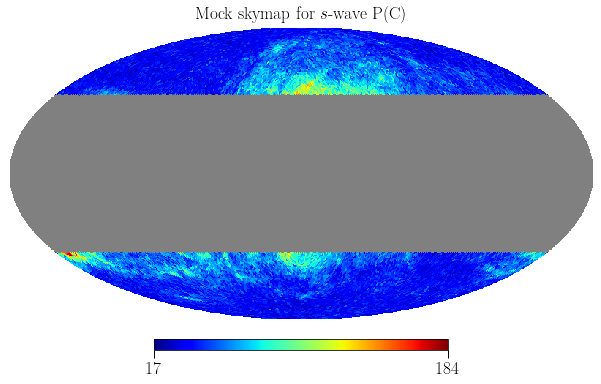

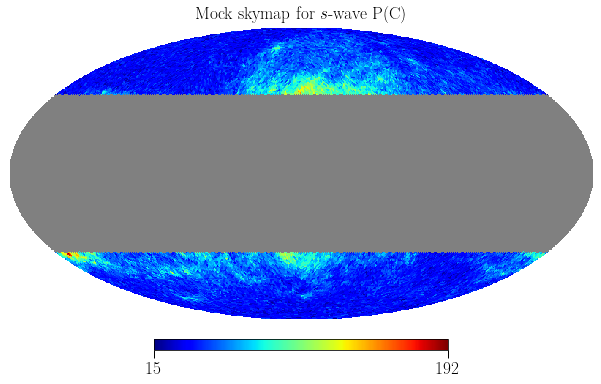

In [22]:
# fiducial fermi exposure and fwimp = phipp swave
s_map = './output/plots/n0_skymap_59674.npy'
som_map = './output/plots/n-1_skymap_81209.npy'

nreduce = 64

pixel_counts_pc = np.load(s_map)
healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_pc), nreduce, pess=True, power=-2), cmap=cm.jet, title=r"Mock skymap for $s$-wave P(C)")

pixel_counts_pc = np.load(som_map)
healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_pc), nreduce, pess=True, power=-2), cmap=cm.jet, title=r"Mock skymap for Som. enh. P(C)")